
# Laboratorio: Búsqueda *Anytime* con Weighted A* (AW-A*)

**Objetivo:** Comprender, implementar y experimentar un algoritmo de búsqueda *anytime* que entrega una solución rápidamente y la **mejora** cuando dispone de más tiempo.



## 1) Motivación (idea clave)
En escenarios con **tiempo limitado** o **entornos dinámicos**, necesitamos una solución *ya* —aunque no sea óptima— que pueda **refinarse** si se dispone de más tiempo.
- Ejemplos: robótica móvil, juegos, planificación de rutas bajo cambios en el mapa.



## 2) Definición formal (resumen)
Un algoritmo *anytime* es aquel que:
- Produce una **solución válida en cualquier momento** (interrumpible).
- **Mejora progresivamente** la calidad de la solución conforme avanza el cómputo.
- Lleva asociada una **medida de calidad** (por ejemplo, la longitud del camino).

**Propiedades usuales:** interruptibilidad, mejora gradual, (idealmente) monotonía de calidad y acotación del error.



## 3) Estrategia: Anytime Weighted A* (AW-A*)
Partimos usando una heurística **inflada** con un factor \( w > 1 \) (prioriza soluciones rápidas).
Luego **disminuimos** gradualmente \( w \) hacia 1.0 (A* clásico), refinando la ruta.

- Si \( f(n) = g(n) + w *h(n) \), al reducir \( w \) nos acercamos a la optimalidad.
- Mantenemos la **mejor cota superior** (longitud de la mejor ruta hallada) para **podar** expansiones inútiles.


In [1]:

%pip install matplotlib

# Requisitos: matplotlib únicamente (ya incluido en este entorno).
import random, time, heapq, math
import matplotlib.pyplot as plt

# Utilidad para visualizar (una figura por gráfico)
def plot_grid(grid, path=None, title="Mapa"):
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(grid, cmap="gray_r")
    if path:
        x, y = zip(*path)
        ax.plot(y, x, linewidth=2, marker="o", markersize=3, label="Ruta")
        ax.scatter([y[0]],[x[0]], s=60, marker="s", label="Inicio")
        ax.scatter([y[-1]],[x[-1]], s=60, marker="s", label="Meta")
    ax.set_title(title, fontsize=14)
    ax.axis("off")
    ax.legend(loc="upper right")
    plt.show()


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 2.8 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.1 MB 2.9 MB/s eta 0:00:03
   --------- ------------------------------ 1.8/8.1 MB 2.5 MB/s eta 0:00:03
   ---------- ----------------------------- 2.1/8.1 MB 2.4 MB/s eta 0:00:03
   ----------- ---------------------------- 2.4/8.1 MB 2.2 MB/s eta 0:00:03
   -------------- ------------------------- 2.9/8.1 MB 2.1 MB/s eta 0:00:03
   --------------- ------------------------ 3.1/8.1 MB 2.1 MB/s eta 0:00:03
   ------------------ --------------------- 3.7/8.1 MB 2.1 MB/s eta 0:00:03
   -------------------- ------------------- 4.2/8.1 MB 2.2 MB/s eta 0:00:02
   ------------------------ --------------- 5.0/8.1 MB 2.3 MB/s eta 0:00:02
   ---------------------


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



### 3.1 Generación de mapas (laberinto)
Usaremos un generador simple por **búsqueda en profundidad** (backtracking) para crear un laberinto 2D.


In [2]:

def generate_maze(width=41, height=41, seed=7):
    random.seed(seed)
    # Asegurar dimensiones impares (corredores de 1 celda, paredes de 1 celda)
    width = width if width % 2 == 1 else width + 1
    height = height if height % 2 == 1 else height + 1
    maze = [[1 for _ in range(width)] for _ in range(height)]  # 1 = muro, 0 = libre

    def neighbors(cx, cy):
        for dx, dy in [(2,0),(-2,0),(0,2),(0,-2)]:
            nx, ny = cx + dx, cy + dy
            if 1 <= nx < height-1 and 1 <= ny < width-1:
                yield nx, ny, dx, dy

    stack = [(1,1)]
    maze[1][1] = 0

    while stack:
        x, y = stack[-1]
        unvisited = [(nx,ny,dx,dy) for nx,ny,dx,dy in neighbors(x,y) if maze[nx][ny] == 1]
        if unvisited:
            nx, ny, dx, dy = random.choice(unvisited)
            maze[x + dx//2][y + dy//2] = 0  # derribar pared intermedia
            maze[nx][ny] = 0
            stack.append((nx, ny))
        else:
            stack.pop()

    # Agregar algunas aperturas aleatorias para permitir múltiples rutas
    openings = (width * height) // 200
    for _ in range(openings):
        x = random.randrange(1, height-1)
        y = random.randrange(1, width-1)
        maze[x][y] = 0

    return maze



### 3.2 Implementación de AW-A*
- Heurística: **Manhattan** (admisible en cuadrícula 4-conexa).
- Ciclos de búsqueda con pesos: \( w = w_{inicio}, w_{inicio}-\Delta, \dots, 1.0 \) hasta agotar tiempo.
- Se mantiene y usa una **cota superior** (mejor ruta encontrada) para **podar** caminos peores.


In [3]:

class Node:
    __slots__ = ("state","parent","g","h","f")
    def __init__(self, state, parent=None, g=0, h=0, w=1.0):
        self.state = state
        self.parent = parent
        self.g = g
        self.h = h
        self.f = g + w*h
    def __lt__(self, other):
        return self.f < other.f

def heuristic(a, b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def reconstruct_path(n):
    path = []
    while n:
        path.append(n.state)
        n = n.parent
    return path[::-1]

def awastar(start, goal, grid, max_time=2.0, w_start=2.5, w_end=1.0, w_step=0.5):
    H = len(grid); W = len(grid[0])
    t0 = time.time()
    best_path = None
    best_len = math.inf

    w = w_start
    while w >= w_end - 1e-9 and (time.time() - t0) < max_time:
        open_list = []
        g_cost = {start: 0}
        h0 = heuristic(start, goal)
        heapq.heappush(open_list, Node(start, None, 0, h0, w))
        closed = set()

        while open_list and (time.time() - t0) < max_time:
            current = heapq.heappop(open_list)
            if current.state in closed:
                continue
            closed.add(current.state)

            # Poda basada en la mejor cota superior disponible
            if current.g + current.h >= best_len:
                continue

            if current.state == goal:
                cand = reconstruct_path(current)
                if len(cand) < best_len:
                    best_len = len(cand)
                    best_path = cand
                break  # Reducimos w y repetimos para refinar
            x, y = current.state
            for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]:
                nx, ny = x+dx, y+dy
                if 0 <= nx < H and 0 <= ny < W and grid[nx][ny] == 0:
                    ng = current.g + 1
                    ns = (nx, ny)
                    if ng < g_cost.get(ns, math.inf):
                        g_cost[ns] = ng
                        h = heuristic(ns, goal)
                        if ng + h >= best_len:
                            continue
                        heapq.heappush(open_list, Node(ns, current, ng, h, w))
        w -= w_step

    return best_path



## 4) Experimentos
### 4.1 Mapa base y comparación de tiempos
Ejecución en un **laberinto 41×41** con tiempos distintos:
- **0.2 s** → solución inicial (rápida).
- **2.5 s** → solución refinada (más corta).


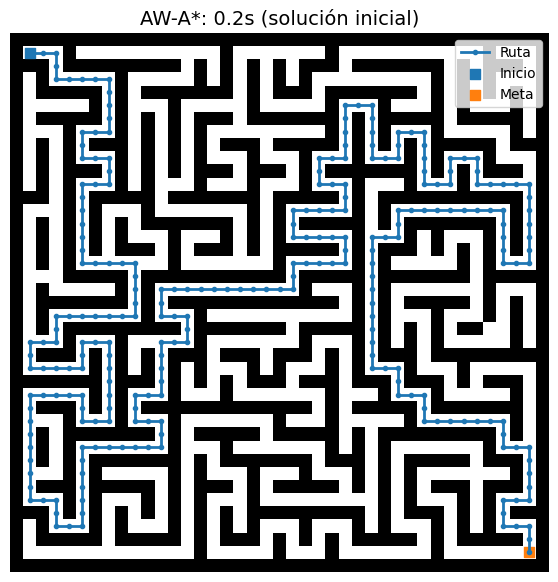

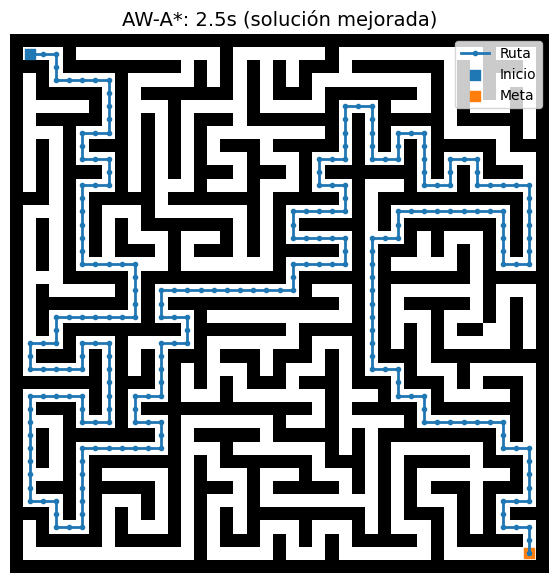

Longitud ruta 0.2s: 249
Longitud ruta 2.5s: 249


In [8]:

maze = generate_maze(41, 41, seed=7)
start = (1,1)
goal = (len(maze)-2, len(maze[0])-2)
maze[start[0]][start[1]] = 0
maze[goal[0]][goal[1]] = 0

path_quick = awastar(start, goal, maze, max_time=0.2, w_start=4.5, w_end=1.0, w_step=0.5)
plot_grid(maze, path_quick, "AW-A*: 0.2s (solución inicial)")

path_longer = awastar(start, goal, maze, max_time=2.5, w_start=2.5, w_end=1.0, w_step=0.5)
plot_grid(maze, path_longer, "AW-A*: 2.5s (solución mejorada)")

print("Longitud ruta 0.2s:", len(path_quick) if path_quick else None)
print("Longitud ruta 2.5s:", len(path_longer) if path_longer else None)



### 4.2 Sensibilidad a tamaño de mapa y semilla
Prueba variando dimensiones y semilla para ver cómo cambia el beneficio *anytime*.


In [9]:

def run_experiment(width, height, seed, t_short=0.15, t_long=2.0):
    maze = generate_maze(width, height, seed=seed)
    start = (1,1)
    goal = (len(maze)-2, len(maze[0])-2)
    maze[start[0]][start[1]] = 0
    maze[goal[0]][goal[1]] = 0

    p1 = awastar(start, goal, maze, max_time=t_short, w_start=2.5, w_end=1.0, w_step=0.5)
    p2 = awastar(start, goal, maze, max_time=t_long,  w_start=2.5, w_end=1.0, w_step=0.5)
    return (len(p1) if p1 else math.inf), (len(p2) if p2 else math.inf)

for (w,h,s) in [(31,31,3), (41,41,7), (51,51,11)]:
    l1, l2 = run_experiment(w,h,s)
    print(f"Mapa {w}x{h} seed={s}: corto={l1}, largo={l2}, mejora={(l1 - l2) if (l1<math.inf and l2<math.inf) else None}")


Mapa 31x31 seed=3: corto=141, largo=141, mejora=0
Mapa 41x41 seed=7: corto=249, largo=249, mejora=0
Mapa 51x51 seed=11: corto=413, largo=413, mejora=0
